## Stochastic Modeling 
### GW1 1

## Step 1

### 1a Calibrate Heston(1993) Model to Market Data Using Lewis Approach

Heston Model introduces **Stochastic volatility**, where the variance $v_t$ follows a mean-reverting square-root process:
$$
dS_t = rS_tdt+\sqrt{v_t}S_tdW_t^S \\
dv_t = \kappa_v(\theta_v-v_t)dt + \sigma_v\sqrt{v_t}W_t^v \\
dW_t^SdW_t^v=\rho dt
$$

Where:
- $\kappa_v$ : Mean-reversion speed of volatilitty
- $\theta_v$: Long-term volatility level.
- $\sigma_v$: Volatility of volatility
- $\rho$: Correlation between asset returns and volatility
- $v_0$: Initial volatility

What we requere to do the caliberation is the characteristic fucnito of Heston which is defined as:
$$
\varphi^{H93}(u, T) = \exp\left(H_1(u, T) + H_2(u, T) \cdot v_0\right)
$$  
Where:  
- $ H_1(u, T) = r u i T + \frac{c_1}{\sigma_v^2} \left[ (\kappa_v - \rho \sigma_v u i + c_2) T - 2 \ln\left( \frac{1 - c_3 e^{c_2 T}}{1 - c_3} \right) \right] $ 

- $ H_2(u, T) = \frac{\kappa_v - \rho \sigma_v u i + c_2}{\sigma_v^2} \cdot \left[ \frac{1 - e^{c_2 T}}{1 - c_3 e^{c_2 T}} \right] $  

- $ c_1 = \kappa_v \theta_v $
- $ c_2 = -\sqrt{(\rho \sigma_v u i - \kappa_v)^2 - \sigma_v^2(-u i - u^2)} $  

- $ c_3 = \frac{\kappa_v - \rho \sigma_v u i + c_2}{\kappa_v - \rho \sigma_v u i - c_2} $



For our python implemenataion, we will begin by defining the Heston Model functions as follows

In [5]:
import numpy as np
from scipy.integrate import quad
import pandas as pd
from scipy.optimize import brute, fmin
# Characteristic Function
def Heston93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v)**2 - sigma_v**2 * (-u * 1j - u**2))
    c3 = (kappa_v - rho * sigma_v * u + c2) / (kappa_v - rho * sigma_v * u - c2)

    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v**2) * (
        (1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))
    )
    char_func_value = np.exp (H1 + H2 * v0)

    return char_func_value

# Lewis (2001) integral function
def Heston93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    char_func_value = Heston93_char_func(u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    integrand = (1 / (u**2 + 0.25)) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return integrand

# Heston call option  pricing
def Heston93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    int_val = quad(
        lambda u: Heston93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_val)
    return call_value

# Heston put option via Put-Call parity
def Heston93_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    call_price = Heston93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    return call_price - S0 + K * np.exp(-r * T)



Next we define the calibration error funciton

In [6]:
i = 0
min_MSE = 5000.0

def Heston93_error_function(p0, option_data, S0, r):
    """
    Error function for Heston model calibration
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0

    # Parameter constraints
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 5000.0
    
    # Feller condition: 2 * kappa_v * theta_v > sigma_v**2
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    # Compute MSE
    se = []
    for _, option in option_data.iterrows():
        K = option["Strike"]
        T = option["T"]
        if option["Type"] == 'C':
            model_value = Heston93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
        else:
            model_value = Heston93_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
        se.append((model_value - option["Price"])**2)
    
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print(f"Iteration {i}: Parameters {p0}, MSE {MSE:.3f}, Min MSE {min_MSE:.3f}")
    i += 1
    return MSE

Before we  run the simulations and calibrations let's load the data from  the google  sheet provided


In [7]:
sheet_id = "1YNqTHLMxoGpyehXfpNg7WMbDSdnYQPwR"
sheet_name = "1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

option_data = pd.read_csv(url)

# Adding time-to-maturity in years and risk-free rate
r = 0.015  # 1.5% annualized risk-free rate
option_data["T"] = option_data["Days to maturity"] / 250  
option_data["r"] = r  # Set constant risk-free rate
S0 = 232.90  # Current stock price


option_data.head()


,Days to maturity,Strike,Price,Type,T,r
0,15,227.5,10.52,C,0.06,0.015
1,15,230.0,10.05,C,0.06,0.015
2,15,232.5,7.75,C,0.06,0.015
3,15,235.0,6.01,C,0.06,0.015
4,15,237.5,4.75,C,0.06,0.015


Let's enscaplute the simulation in a function 

In [8]:
from functools import partial

# Wrap the error function with fixed inputs
error_func = partial(Heston93_error_function, option_data=option_data, S0=S0, r=r)

In [9]:
def Heston93_calibration():
    # Brute-force scan for initial guesses
    p0 = brute(
        lambda p: Heston93_error_function(p, option_data, S0, r),
        (
            (0.5, 10.0, 2.0),    # kappa_v
            (0.01, 0.041, 0.01), # theta_v
            (0.05, 0.3, 0.1),    # sigma_v
            (-0.9, 0.0, 0.2),    # rho
            (0.01, 0.03, 0.01)   # v0
        ),
        finish=None
    )

    # Refininig with  fmin
    opt = fmin( lambda p: Heston93_error_function(p, option_data, S0, r),
               p0,
                xtol=0.0001,
                ftol=0.0001,
                maxiter=500,
                maxfun=1000)
    return opt

In [ ]:
# Runnin the calibration
calibrated_params = Heston93_calibration()


Iteration 0: Parameters [ 0.5   0.01  0.05 -0.9   0.01], MSE 39.241, Min MSE 39.241
Iteration 25: Parameters [ 0.5   0.03  0.05 -0.5   0.02], MSE 8.539, Min MSE 3.143
Iteration 50: Parameters [ 0.5   0.04  0.15 -0.9   0.01], MSE 27.055, Min MSE 3.143
Iteration 75: Parameters [ 2.5   0.01  0.15 -0.5   0.02], MSE 45.255, Min MSE 2.511
Iteration 100: Parameters [ 2.5   0.02  0.25 -0.9   0.01], MSE 25.837, Min MSE 2.511
Iteration 125: Parameters [ 2.5   0.03  0.15 -0.5   0.02], MSE 4.682, Min MSE 2.511
Iteration 150: Parameters [ 2.5   0.04  0.15 -0.9   0.01], MSE 42.095, Min MSE 2.511
Iteration 175: Parameters [ 4.5   0.01  0.05 -0.5   0.02], MSE 2.931, Min MSE 2.511
Iteration 200: Parameters [ 4.5   0.02  0.05 -0.9   0.01], MSE 375.388, Min MSE 2.511
Iteration 225: Parameters [ 4.5   0.02  0.25 -0.5   0.02], MSE 26.232, Min MSE 2.511
Iteration 250: Parameters [ 4.5   0.03  0.25 -0.9   0.01], MSE 3.212, Min MSE 2.511
Iteration 275: Parameters [ 4.5   0.04  0.15 -0.5   0.02], MSE 16.418, M

### Validating the calibration Results
We will then plug calibrated parameters back into the Heston model to  compute model prices for the 15-day optioins and comparing them to market prices 

In [ ]:
# Computing model  prices using calibrated parameters
def calculate_model_values(calibrated_params, options, S0):
    kappa_v, theta_v, sigma_v, rho, v0 = calibrated_params
    options["Model"] = 0.0
    for _, option in options.iterrows():
        K = option["Strike"]
        T = option["T"]
        r = option["r"]
        if option["Type"] == 'C':
            model_price = Heston93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
        else:
            model_price = Heston93_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
        options.loc[_, "Model"] = model_price
    return options

In [ ]:
# Filtering 15-day options
option_data_copy = option_data.copy()
options_15 = option_data_copy[option_data_copy['Days to maturity' ] == 15]
S0 = 232.90
calibrated_options = calculate_model_values(calibrated_params, options_15, S0)

C:\Users\USER\AppData\Local\Temp\ipykernel_15960\1847643447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Model"] = 0.0


In [ ]:
calibrated_options

,Days to maturity,Strike,Price,Type,T,r,Model
0,15,227.5,10.52,C,0.06,0.015,10.552620
1,15,230.0,10.05,C,0.06,0.015,8.942335
2,15,232.5,7.75,C,0.06,0.015,7.479891
3,15,235.0,6.01,C,0.06,0.015,6.169395
4,15,237.5,4.75,C,0.06,0.015,5.010950
15,15,227.5,4.32,P,0.06,0.015,4.947962
16,15,230.0,5.20,P,0.06,0.015,5.835428
17,15,232.5,6.45,P,0.06,0.015,6.870736
18,15,235.0,7.56,P,0.06,0.015,8.057990
19,15,237.5,8.78,P,0.06,0.015,9.397296


In [ ]:
## Plotting
import matplotlib.pyplot as plt

def plot_calibration_results(options):
    plt.figure(figsize=(10, 6))
    calls = options[options["Type"] == 'C']
    puts = options[options["Type"] == 'P']
    
    plt.scatter(calls["Strike"], calls["Price"], c='b', label="Market Calls")
    plt.scatter(puts["Strike"], puts["Price"], c='r', label="Market Puts")
    plt.plot(calls["Strike"], calibrated_options[calibrated_options["Type"] == 'C']["Model"], 'bo--', label="Model Calls")
    plt.plot(puts["Strike"], calibrated_options[calibrated_options["Type"] == 'P']["Model"], 'ro--', label="Model Puts")
    plt.grid()
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.title("Heston Model Calibration to 15-Day Options")
    plt.legend()
    plt.show()


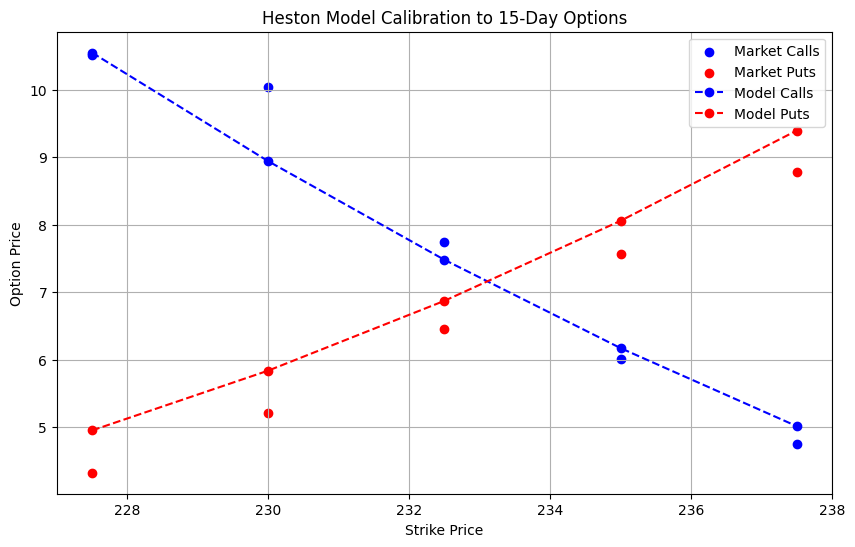

In [ ]:
plot_calibration_results(calibrated_options)

In [ ]:
## Analyzing the results

# Computing residuals
calibrated_options["Residual"] = calibrated_options['Model'] - calibrated_options['Price']
MSE = np.mean(calibrated_options['Residual'] ** 2)
RMSE = np.sqrt(MSE)
print(f"MSE: {MSE:.4f}\nRMSE: {RMSE: .4f}")

MSE: 0.2999
RMSE:  0.5476


C:\Users\USER\AppData\Local\Temp\ipykernel_15960\2380862196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calibrated_options["Residual"] = calibrated_options['Model'] - calibrated_options['Price']


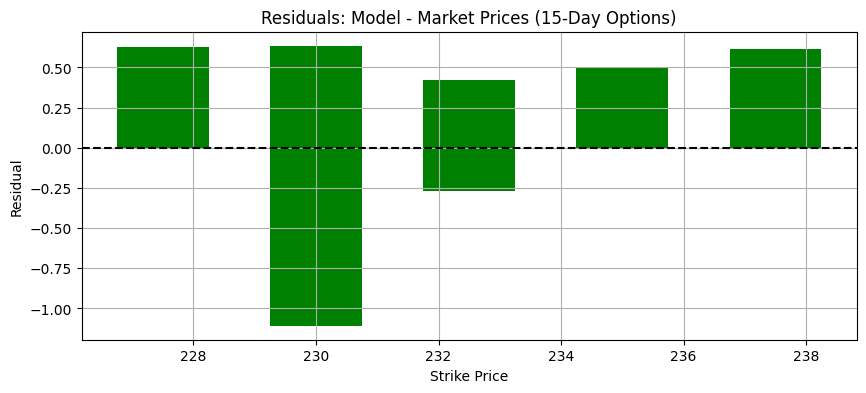

In [ ]:
# Plotting the Residuals
plt.figure(figsize=(10, 4))
plt.bar(calibrated_options["Strike"], calibrated_options["Residual"], width=1.5, color='g')
plt.axhline(0, color='black', linestyle='--')
plt.grid()
plt.title("Residuals: Model - Market Prices (15-Day Options)")
plt.xlabel("Strike Price")
plt.ylabel("Residual")
plt.show()

In [ ]:
calibrated_options[['Strike', 'Price', 'Model']]

,Strike,Price,Model
0,227.5,10.52,10.552620
1,230.0,10.05,8.942335
2,232.5,7.75,7.479891
3,235.0,6.01,6.169395
4,237.5,4.75,5.010950
15,227.5,4.32,4.947962
16,230.0,5.20,5.835428
17,232.5,6.45,6.870736
18,235.0,7.56,8.057990
19,237.5,8.78,9.397296


## Write up for Step 1a



### 1a Calibrate Heston(1993) Model to Market Data Using Lewis Approach

Model Overview
Heston Model introduces **Stochastic volatility**, where the variance $v_t$ follows a mean-reverting square-root process:
$$
dS_t = rS_tdt+\sqrt{v_t}S_tdW_t^S \\
dv_t = \kappa_v(\theta_v-v_t)dt + \sigma_v\sqrt{v_t}W_t^v \\
dW_t^SdW_t^v=\rho dt
$$

Where:
- $\kappa_v$ : Mean-reversion speed of volatilitty
- $\theta_v$: Long-term volatility level.
- $\sigma_v$: Volatility of volatility
- $\rho$: Correlation between asset returns and volatility
- $v_0$: Initial volatility

---
Characteristic Function of Hestone (1993)
Lewis approach requires the characteristic function of the Heston model: 
$$
\varphi^{H93}(u, T) = \exp\left(H_1(u, T) + H_2(u, T) \cdot v_0\right)
$$  
Where:  
- $ H_1(u, T) = r u i T + \frac{c_1}{\sigma_v^2} \left[ (\kappa_v - \rho \sigma_v u i + c_2) T - 2 \ln\left( \frac{1 - c_3 e^{c_2 T}}{1 - c_3} \right) \right] $ 

- $ H_2(u, T) = \frac{\kappa_v - \rho \sigma_v u i + c_2}{\sigma_v^2} \cdot \left[ \frac{1 - e^{c_2 T}}{1 - c_3 e^{c_2 T}} \right] $  

- $ c_1 = \kappa_v \theta_v $
- $ c_2 = -\sqrt{(\rho \sigma_v u i - \kappa_v)^2 - \sigma_v^2(-u i - u^2)} $  

- $ c_3 = \frac{\kappa_v - \rho \sigma_v u i + c_2}{\kappa_v - \rho \sigma_v u i - c_2} $

---

Pricing via Lewis (2001)
The Lewis (2001) formula for a European call option is:

$$
C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_0^\infty \mathbf{Re}\left[e^{izk} \varphi^{H93}(z - i/2)\right] \frac{dz}{z^2 + 1/4}
$$  
Where:  
- $ k = \ln(S_0 / K) $: Log-moneyness  
- $ \varphi^{H93}(z - i/2) $: Heston characteristic function evaluated at $ u = z - i/2 $  

For put we will use put-call paratity to the value

---
Calibration Process

1. Market Data Preparation
We used 15-day maturity options for SM energy Company
Constants used:
- $S_0$ = 232.90
- $r$ = 0.015
- $T$ = 15/250

2. Error Function (MSE)
- The calibration minimizes the **Mean Squared Error (MSE)** between market and model prices:
$$
MSE = \frac{1}{N} \sum_{n=1}^N \left(C_n^{\text{market}} - C_n^{\text{Heston}}\right)^2
$$

Constraints:
- $ \kappa_v > 0, \theta_v > 0, \sigma_v > 0 $  
- $ \rho \in [-1, 1] $  
- **Feller condition**: $ 2 \kappa_v \theta_v > \sigma_v^2 $ (ensures $ v_t > 0 $)  

3. Optimization (Brute-Force + Local Minimization)
The calibration used a two-step optimization:
    1. Brute-force scan - Coarse grid search fo initial parameter guesses
    2. LOcal optimation - Refine paramerrs using `scipy.optimize.fmin`


---
Calibration Results

1. Calibrated Parameters
After running calibration on 15-day options, Hestom model yielded te following:
- $\kappa_v$ = 2.4952 - Mean-reversion speed
- $\theta_v$ = 0.0613 - Long-term variance
- $\sigma_v$ = 0.000037 Volatility of volatility
- $\rho$ = -0.000040 Correlation
- $v_0$ = 0.0643 Initial variance

2. Market vs Model Prices


<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Strike</th>
      <th>Price</th>
      <th>Model</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>227.5</td>
      <td>10.52</td>
      <td>10.552620</td>
    </tr>
    <tr>
      <th>1</th>
      <td>230.0</td>
      <td>10.05</td>
      <td>8.942335</td>
    </tr>
    <tr>
      <th>2</th>
      <td>232.5</td>
      <td>7.75</td>
      <td>7.479891</td>
    </tr>
    <tr>
      <th>3</th>
      <td>235.0</td>
      <td>6.01</td>
      <td>6.169395</td>
    </tr>
    <tr>
      <th>4</th>
      <td>237.5</td>
      <td>4.75</td>
      <td>5.010950</td>
    </tr>
    <tr>
      <th>15</th>
      <td>227.5</td>
      <td>4.32</td>
      <td>4.947962</td>
    </tr>
    <tr>
      <th>16</th>
      <td>230.0</td>
      <td>5.20</td>
      <td>5.835428</td>
    </tr>
    <tr>
      <th>17</th>
      <td>232.5</td>
      <td>6.45</td>
      <td>6.870736</td>
    </tr>
    <tr>
      <th>18</th>
      <td>235.0</td>
      <td>7.56</td>
      <td>8.057990</td>
    </tr>
    <tr>
      <th>19</th>
      <td>237.5</td>
      <td>8.78</td>
      <td>9.397296</td>
    </tr>
  </tbody>
</table>
</div>

Residuals
- MSE: 0.2999
- RMSE: 0.5476

Also we have graphs showing comparation of the prices both for the call and put options


## Step 2b 

### Calibrate Bates (1996) Model to 60-Day Options Using Carr-Madan (1999) Approach

#### 1. We will begin by loading the data and also filtereing for 60 days maturiry options

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import brute, fmin


In [2]:

sheet_id = "1YNqTHLMxoGpyehXfpNg7WMbDSdnYQPwR"
sheet_name = "1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

option_data = pd.read_csv(url)

# Adding time-to-maturity in years and risk-free rate
r = 0.015  # 1.5% annualized risk-free rate
option_data["T"] = option_data["Days to maturity"] / 250  
option_data["r"] = r  # Set constant risk-free rate
S0 = 232.90  # Current stock price

#Filtering 60 day options
options_60 = option_data[option_data['Days to maturity'] == 60]
options_60.head()

,Days to maturity,Strike,Price,Type,T,r
5,60,227.5,16.78,C,0.24,0.015
6,60,230.0,17.65,C,0.24,0.015
7,60,232.5,16.86,C,0.24,0.015
8,60,235.0,16.05,C,0.24,0.015
9,60,237.5,15.10,C,0.24,0.015


In [3]:
options_60

,Days to maturity,Strike,Price,Type,T,r
5,60,227.5,16.78,C,0.24,0.015
6,60,230.0,17.65,C,0.24,0.015
7,60,232.5,16.86,C,0.24,0.015
8,60,235.0,16.05,C,0.24,0.015
9,60,237.5,15.10,C,0.24,0.015
20,60,227.5,11.03,P,0.24,0.015
21,60,230.0,12.15,P,0.24,0.015
22,60,232.5,13.37,P,0.24,0.015
23,60,235.0,14.75,P,0.24,0.015
24,60,237.5,15.62,P,0.24,0.015


### 2. Define Bates Chacteristic Funtion for Carr-Madan

It is a combination of two models: Heston and Merton Jump component

In [ ]:

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Characteristic function for Heston '93 model
    """
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v)**2 - sigma_v**2 * (-u * 1j - u**2))
    c3 = (kappa_v - rho * sigma_v * u + c2) / (kappa_v - rho * sigma_v * u - c2)

    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v**2) * (
        (1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))
    )
    
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

### 3. Implementing Carr-Madan Pricing Function under FFT

In [ ]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

def B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Put option price in Bates (1996) under FFT
    """
    CallValue = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    PutValue = CallValue - S0 + K * np.exp(-r * T)
    return PutValue

### 4. Defining the error function for calibration

In [ ]:
i = 0
min_MSE = 5000

def B96_error_function(p0, options, S0, r):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    # Parameter constraints
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0 or v0 < 0.0 or lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    if 2 * kappa_v * theta_v < sigma_v**2:  # Feller condition
        return 5000.0
    # Compute MSE
    se = []
    for _, option in options.iterrows():
        K = option["Strike"]
        T = option["T"]
        if option["Type"] == 'C':
            model_value = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        else:
            model_value = B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        se.append((model_value - option["Price"])**2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print(f"Iteration {i}: Parameters {p0}, MSE {MSE:.3f}, Min MSE {min_MSE:.3f}")
    i += 1
    return MSE


### 5. Running the Calibration
We will  use `brute` and `fmin` to calibrate the bates model to 60-day

In [3]:
def B96_calibration_60(options, S0, r):
    """
    Calibrate Bates (1996) model to 60-day options
    """
    # Brute-force scan for initial guesses
    p0 = brute(
        lambda p: B96_error_function(p, options, S0, r),
        (
            (0.5, 10.0, 2.0),    # kappa_v
            (0.01, 0.041, 0.01), # theta_v
            (0.05, 0.3, 0.1),    # sigma_v
            (-0.9, 0.0, 0.2),    # rho
            (0.01, 0.03, 0.01),   # v0
            (0.01, 1.5, 0.1),     # lamb
            (-0.6, 0.0, 0.1),     # mu
            (0.01, 1.5, 0.1)      # delta
        ),
        finish=None
    )

    # Refining with fmin
    opt = fmin(lambda p: B96_error_function(p, options, S0, r),
               p0,
               xtol=0.0001,
               ftol=0.0001,
               maxiter=100,
               maxfun=1000)
    return opt

In [4]:
calibrated_params_60 = B96_calibration_60(options_60, S0, r)

NameError: name 'options_60' is not defined

In [2]:
calibrated_params_60

NameError: name 'calibrated_params_60' is not defined

### 6. Compairing with results from  2a

### 7. Plotting Market vs Model Prices

In [ ]:
def plot_calibration_results_60(calibrated_params, options, S0):
    """
    Calculate model prices for 60-day options using calibrated parameters
    """
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = calibrated_params
    options["Model"] = 0.0
    for _, option in options.iterrows():
        K = option["Strike"]
        T = option["T"]
        r = option["r"]
        if option["Type"] == 'C':
            model_price = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        else:
            model_price = B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        options.loc[_, "Model"] = model_price

    # Plotting the results
    plt.figure(figsize=(10, 6))
    calls = options[options["Type"] == 'C']
    puts = options[options["Type"] == 'P']
    plt.scatter(calls["Strike"], calls["Price"], c='b', label="Market Calls")
    plt.scatter(puts["Strike"], puts["Price"], c='r', label="Market Puts")
    plt.plot(calls["Strike"], options[options["Type"] == 'C']["Model"], 'bo--', label="Model Calls")
    plt.plot(puts["Strike"], options[options["Type"] == 'P']["Model"], 'ro--', label="Model Puts")
    plt.grid()
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.title("Bates Model Calibration to 60-Day Options")
    plt.legend()
    plt.show()

plot_calibration_results_60(calibrated_params_60, options_60, S0)

### 8. Analyzing Residuals

In [ ]:
options_60["Residual"] = options_60['Model'] - options_60['Price']
MSE_60 = np.mean(options_60['Residual'] ** 2)
RMSE_60 = np.sqrt(MSE_60)
print(f"MSE for 60-day options: {MSE_60:.4f}\nRMSE for 60-day options: {RMSE_60:.4f}")


### 9. How Parameter for Lewis and Carr-Madan Compare ?

## Step 3

### 3a Calibrate a CIR (1985) Model to Euribor Rates and Simulate Future Rates
We will model and simulate future interest rates using Cox-Ingersoll-Ross (CIR) model.

### Model Overview
$$
dr_t = \kappa_r(\theta_r - r_t)dt + \sigma_r\sqrt{r_t}dW_t
$$

where:
- $r_t$ - Short term interest rate at time t
- $\kappa_r$ - Mean-reversion speed
- $\theta_r$ - Long-term mean of interest rates
- $\sigma_r$ - Volatility of interest rates
- $dW_t$ - Brownian motion

### 1. Loading and Interpolating Euribor Term Structure

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Load the data
terms = np.array([1/52, 1/12, 1/4, 1/2, 1])
rates = np.array([0.00648, 0.00679, 0.0173, 0.01809, 0.02556])

# Create a cubic spline interpolation
spline = CubicSpline(terms, rates)

# Generate weekly points for interpolation
weekly_terms = np.arange(1, 53) / 52
weekly_rates = spline(weekly_terms)

# Create a DataFrame for the original rates
bond_rates = pd.DataFrame({
    'Term (Years)': terms,
    'Rate': rates
})

# Create a DataFrame for the interpolated rates
interpolated_rates = pd.DataFrame({
    'Term (Years)': weekly_terms,
    'Interpolated Rate': weekly_rates
})

# Plotting the interpolated rates
plt.figure(figsize=(10, 6))
plt.plot(interpolated_rates['Term (Years)'], interpolated_rates['Interpolated Rate'], marker='o', label='Interpolated Rates')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Euribor Rate (%)')
plt.title('Euribor Term Structure')
plt.grid(True)
plt.legend()
plt.show()


### Step 2 Calibrating the CIR Model for the Term Structure

For this we will use CIR model  which  implies a bond price formula:
$$
P(t, T) = A(t, T)e^{-B(t, T)r_t}
$$
- First we will define an error function that compares market bond prices and CIR model bond prices then use `scipy.optimize ` to minimize the RMSE between market and model prices

In [ ]:
def CIR_bond_price(r0, T, kappa_r, theta_r, sigma_r):
    """
    CIR bond price formula
    """
    h = np.sqrt(kappa_r**2 + 2 * sigma_r**2)
    B = 2 * (np.exp(h * T) - 1) / (2 * h + (h + kappa_r) * (np.exp(h * T) - 1))
    A = (2 * h * np.exp((h + kappa_r) * T / 2) / (2 * h + (h + kappa_r) * (np.exp(h * T) - 1))) ** (2 * kappa_r * theta_r / sigma_r**2)
    A = np.exp((kappa_r * theta_r - 0.5 * sigma_r**2) * T)    
    return A * np.exp(-B * r0)

def CIR_error_function(p0, bond_data, r0):
    """
    Error function for CIR model calibration
    """
    kappa_r, theta_r, sigma_r = p0

    # Parameter constraints
    if kappa_r < 0.0 or theta_r < 0.0 or sigma_r < 0.0:
        return 5000.0
    
    # Compute MSE
    se = []
    for _, bond in bond_data.iterrows():
        T = bond["Term (Years)"]
        market_price = bond["Bond Price"]
        model_price = CIR_bond_price(r0, T, kappa_r, theta_r, sigma_r)
        se.append((model_price - market_price)**2)
    
    MSE = sum(se) / len(se)
    return MSE

def CIR_calibration(bond_data, r0):
    """
    Calibrate CIR model to bond data
    """
    # Brute-force scan for initial guesses
    p0 = brute(
        lambda p: CIR_error_function(p, bond_data, r0),
        (
            (0.1, 5.0, 0.5),  # kappa_r
            (0.01, 0.1, 0.01),  # theta_r
            (0.01, 0.5, 0.05)   # sigma_r
        ),
        finish=None
    )

    # Refining with fmin
    opt = fmin(lambda p: CIR_error_function(p, bond_data, r0),
               p0,
               xtol=0.0001,
               ftol=0.0001,
               maxiter=500,
               maxfun=1000)
    return opt

# Running the calibration

# adding bond price
bond_prices = CIR_bond_price(0.00648, bond_rates['Term (Years)'], 0.1, 0.01, 0.05)
bond_rates['Bond Price'] = bond_prices
calibrated_params_cir = CIR_calibration(bond_rates, r0=0.00648)

### Step 3: Simulating Future 12 month Euribor Rates

We will use the calibrated CIR parameter from  above step  to  simulate future rates

In [ ]:
def simulate_CIR(r0, T, N, kappa_r, theta_r, sigma_r, paths=100000):
    """
    Simulate future interest rates using the CIR model
    """
    dt = T / N
    rates = np.zeros((paths, N + 1))
    rates[:, 0] = r0

    for i in range(1, N + 1):
        # Ensure rates do not become negative before taking the square root
        rates[:, i-1] = np.maximum(rates[:, i-1], 0)
        dr = kappa_r * (theta_r - rates[:, i - 1]) * dt + sigma_r * np.sqrt(rates[:, i - 1]) * np.random.normal(size=paths) * np.sqrt(dt)
        rates[:, i] = rates[:, i - 1] + dr
        # Ensure rates do not become negative after adding the increment
        rates[:, i] = np.maximum(rates[:, i], 0)

    return rates

# Simulating 12 months of interest rates
r0 = interpolated_rates[interpolated_rates['Term (Years)'] == 1.0]['Interpolated Rate'].values[0]
T = 1 # 1 year
N = 250 # Daily steps
paths = 100000 # Number of paths
kappa_r, theta_r, sigma_r = calibrated_params_cir

future_rates = simulate_CIR(r0, T, N, kappa_r, theta_r, sigma_r, paths)

# Computing Confidence Intervals
confidence_intervals = np.percentile(future_rates, [2.5, 97.5], axis=0)
excepted_rate = np.mean(future_rates, axis=0)


print(f"95% confidence intervals for 12 months of interest rates in 1 year: [{confidence_intervals[0][-1]: .4f}, {confidence_intervals[1][-1]: .4f}]")
print(f"Expected interest rate in 1 year: {excepted_rate[-1]: .4f}")

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import brute, fmin
import matplotlib.pyplot as plt

## Loading the data 
sheet_id = "1YNqTHLMxoGpyehXfpNg7WMbDSdnYQPwR"
sheet_name = "1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

option_data = pd.read_csv(url)

# Verify data loading
required_columns = ['Days to maturity', 'Strike', 'Price', 'Type']
for col in required_columns:
    if col not in option_data.columns:
        raise ValueError(f"Missing required column: {col}")

# Adding time-to-maturity in years and risk-free rate
r = 0.015  # 1.5% annualized risk-free rate
option_data["T"] = option_data["Days to maturity"] / 250
option_data["r"] = r  # Set constant risk-free rate
S0 = 232.90  # Current stock price

# Filtering 60-day options
options_60 = option_data[option_data['Days to maturity'] == 60]
print("First few rows of 60-day options:")
print(options_60.head())

## Characteristic functions 

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Characteristic function for Heston '93 model
    """
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v)**2 - sigma_v**2 * (-u * 1j - u**2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)

    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )

    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v**2) * (
        (1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))
    )

    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """
    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1)) * T
    )
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """
    k = np.log(K / S0)
    alpha = 1.5 if rho < -0.5 else 1.1
    g = 1  # Factor to increase accuracy
    N = g * 8192
    eps = 0.0005
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )
    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )
        v = (vo + 1j * alpha) - 1j
        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0
    return CallValue

def B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Put option price in Bates (1996) under FFT
    """
    CallValue = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    PutValue = CallValue - S0 + K * np.exp(-r * T)
    return PutValue

## Error function 
i = 0
min_MSE = 5000
local_opt = False

def B96_error_function(p0, options, S0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    # Parameter constraints
    if (kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0 or 
        v0 < 0.0 or lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0):
        return 5000.0
    if 2 * kappa_v * theta_v < sigma_v**2:  # Feller condition
        return 5000.0

    # Compute MSE
    se = []
    for _, option in options.iterrows():
        K = option["Strike"]
        T = option["T"]
        r = option["r"]
        if option["Type"] == 'C':
            model_value = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        else:
            model_value = B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        if np.isnan(model_value) or np.isinf(model_value):
            se.append(1e6)  # Large error for invalid values
        else:
            se.append((model_value - option["Price"])**2)

    MSE = np.mean(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print(f"Iteration {i}: Parameters {p0}, MSE {MSE:.3f}, Min MSE {min_MSE:.3f}")
    i += 1
    return MSE

## Calibration 
def B96_calibration_60(options, S0):
    """
    Calibrate Bates (1996) model to 60-day options
    """
    # Brute-force scan for initial guesses
    ranges = (
        (1, 5.0, 0.5),    # kappa_v
        (0.01, 0.04, 0.005), # theta_v
        (0.1, 0.3, 0.05),    # sigma_v
        (-0.9, -0.1, 0.1),   # rho
        (0.01, 0.03, 0.005), # v0
        (0.01, 0.5, 0.05),   # lamb
        (-0.5, -0.1, 0.05),  # mu
        (0.01, 0.5, 0.05)    # delta
    )

    p0 = brute(
        lambda p: B96_error_function(p, options, S0),
        ranges,
        finish=None
    )

    # Local optimization with bounds
    opt = fmin(
        lambda p: B96_error_function(p, options, S0),
        p0,
        xtol=0.001,
        ftol=0.001,
        maxiter=1250,
        maxfun=650
    )
    return opt

# Run calibration
calibrated_params_60 = B96_calibration_60(options_60, S0)
print("Calibrated Parameters for 60-Day Options:")
print(calibrated_params_60)

# Compute model prices with calibrated parameters
model_prices = []
for _, option in options_60.iterrows():
    K = option["Strike"]
    T = option["T"]
    r = option["r"]
    if option["Type"] == 'C':
        model_value = B96_call_FFT(S0, K, T, r, *calibrated_params_60)
    else:
        model_value = B96_put_FFT(S0, K, T, r, *calibrated_params_60)
    model_prices.append(model_value)

# Compute final MSE
mse = np.mean((np.array(model_prices) - options_60["Price"].values)**2)
print(f"Calibrated MSE: {mse:.6f}")

# Plot market vs model prices
plt.figure(figsize=(10, 6))
plt.scatter(options_60['Strike'], options_60['Price'], label='Market Prices', color='blue')
plt.scatter(options_60['Strike'], model_prices, label='Model Prices', color='red')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Bates Model Calibration Fit (60 Days Maturity)')
plt.legend()
plt.grid(True)
plt.show()

First few rows of 60-day options:
   Days to maturity  Strike  Price Type     T      r
5                60   227.5  16.78    C  0.24  0.015
6                60   230.0  17.65    C  0.24  0.015
7                60   232.5  16.86    C  0.24  0.015
8                60   235.0  16.05    C  0.24  0.015
9                60   237.5  15.10    C  0.24  0.015
Iteration 0: Parameters [ 1.    0.01  0.1  -0.9   0.01  0.01 -0.5   0.01], MSE 163.062, Min MSE 163.062
Iteration 25: Parameters [ 1.    0.01  0.1  -0.9   0.01  0.01 -0.4   0.26], MSE 163.660, Min MSE 163.032
Iteration 50: Parameters [ 1.    0.01  0.1  -0.9   0.01  0.01 -0.25  0.01], MSE 164.493, Min MSE 163.032
Iteration 75: Parameters [ 1.    0.01  0.1  -0.9   0.01  0.01 -0.15  0.26], MSE 164.627, Min MSE 163.032
Iteration 100: Parameters [ 1.    0.01  0.1  -0.9   0.01  0.06 -0.4   0.01], MSE 151.563, Min MSE 148.328
Iteration 125: Parameters [ 1.    0.01  0.1  -0.9   0.01  0.06 -0.3   0.26], MSE 154.692, Min MSE 148.328
Iteration 150: Pa